# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [1]:
import pandas as pd
import os

from tqdm import tqdm

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

4.9.0


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
## ВАШ КОД для построения модели ##
m = Prophet(yearly_seasonality=True)
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

***3833***

In [9]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2946.810565,2126.753122,2837.744411,2946.810436,2946.810696,-460.358505,-460.358505,-460.358505,-860.392211,-860.392211,-860.392211,400.033706,400.033706,400.033706,0.0,0.0,0.0,2486.452060
379,2016-01-17,2949.818338,2298.247664,3018.669628,2949.818202,2949.818476,-302.854614,-302.854614,-302.854614,-720.106693,-720.106693,-720.106693,417.252079,417.252079,417.252079,0.0,0.0,0.0,2646.963725
380,2016-01-18,2952.826111,3308.462130,4024.290792,2952.825964,2952.826259,714.487614,714.487614,714.487614,282.575348,282.575348,282.575348,431.912266,431.912266,431.912266,0.0,0.0,0.0,3667.313725
381,2016-01-19,2955.833884,3575.795251,4291.781409,2955.833728,2955.834041,981.923697,981.923697,981.923697,538.021502,538.021502,538.021502,443.902195,443.902195,443.902195,0.0,0.0,0.0,3937.757581
382,2016-01-20,2958.841657,3450.490069,4194.320770,2958.841494,2958.841822,874.801160,874.801160,874.801160,421.652595,421.652595,421.652595,453.148565,453.148565,453.148565,0.0,0.0,0.0,3833.642817


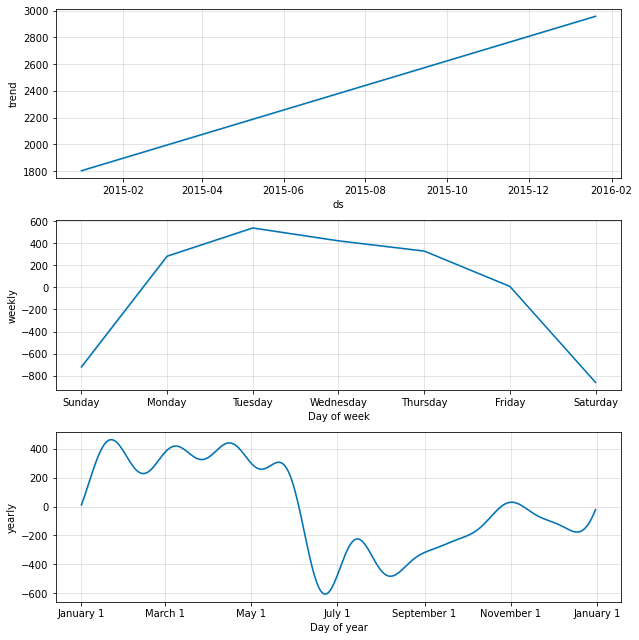

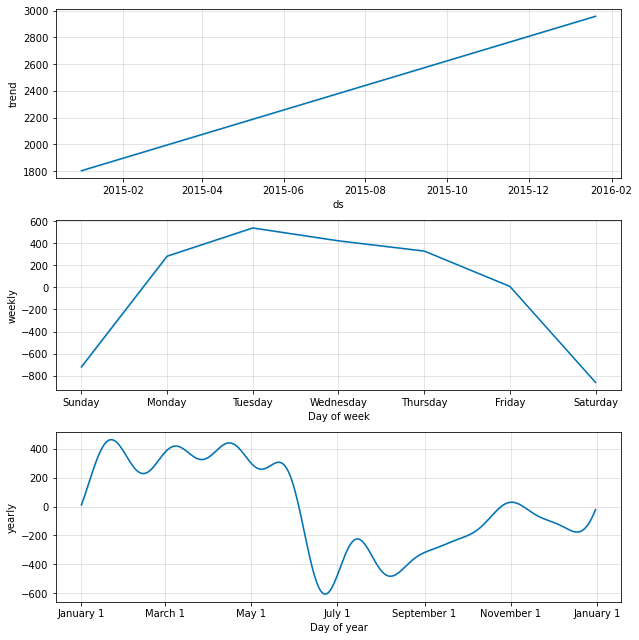

In [10]:
m.plot_components(forecast)

In [11]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [12]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE %.3f' % np.mean(abs(cmp_df[-predictions:]['p'])))
print ('MAE %.3f' % np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 38.413
MAE 713.579


**Вопрос 2**: Какое получилось MAPE?
***38.413***

**Вопрос 3**: Какое получилось MAE?
***713.579***

## Предсказываем с помощью ARIMA

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value? 

***нет***


***p=0.107392***

Критерий Дики-Фуллера: p=0.107392


<Figure size 1080x720 with 0 Axes>

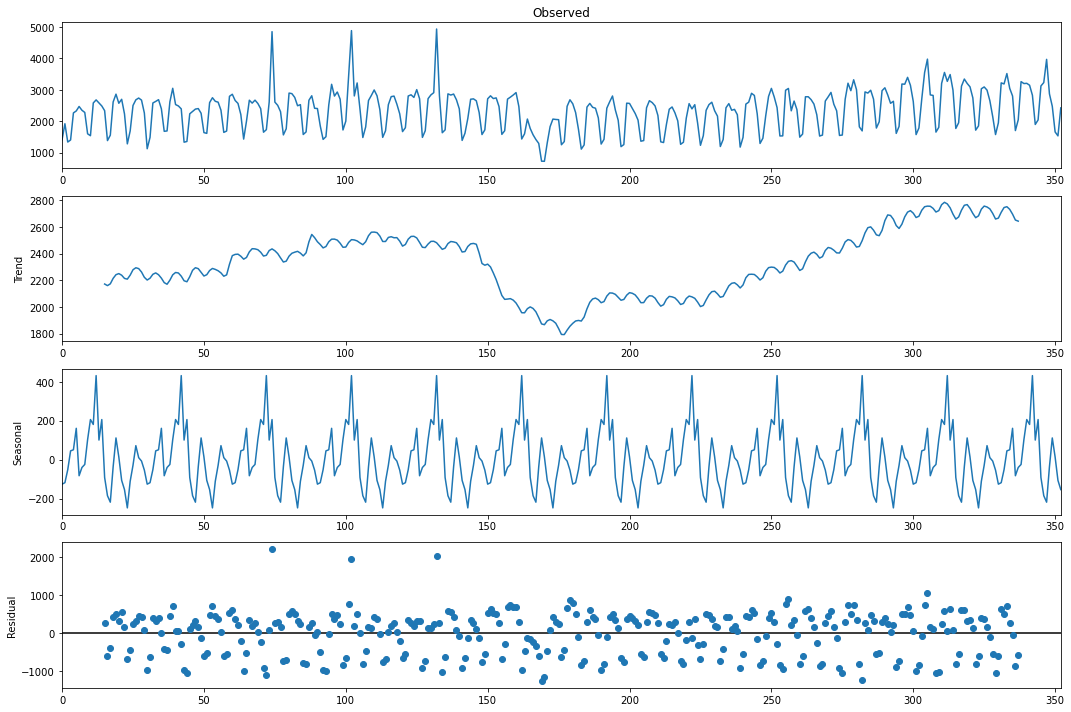

In [14]:
train_df = train_df.set_index('ds')
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, period=30).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1]);

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



Критерий Дики-Фуллера: p=0.000000


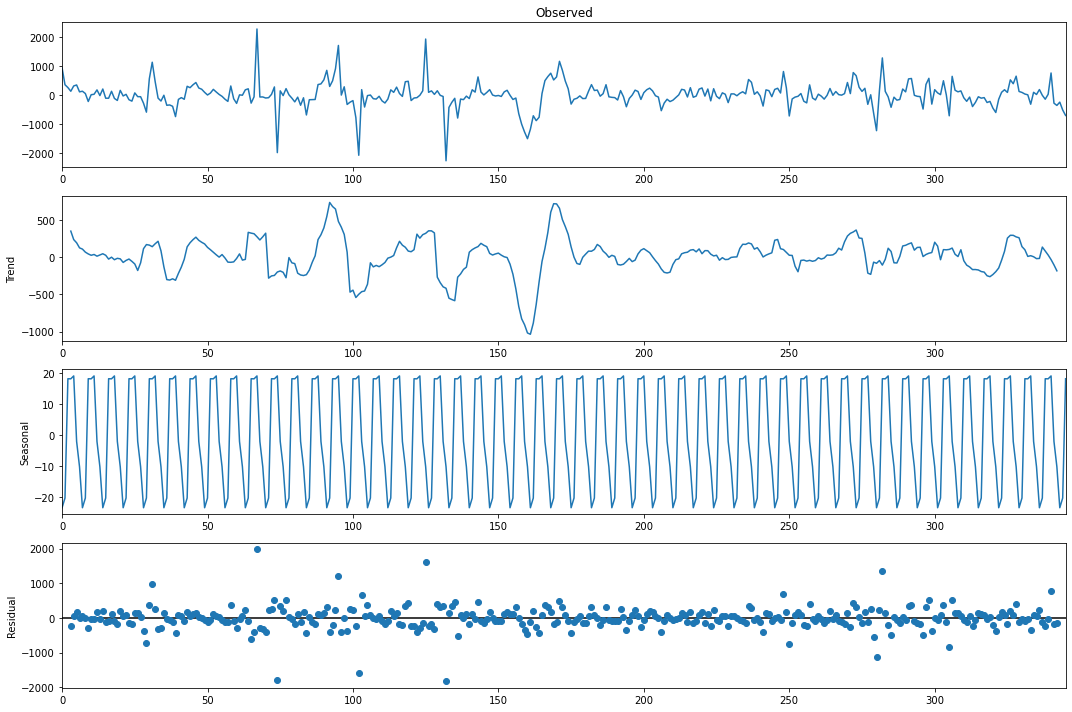

In [15]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

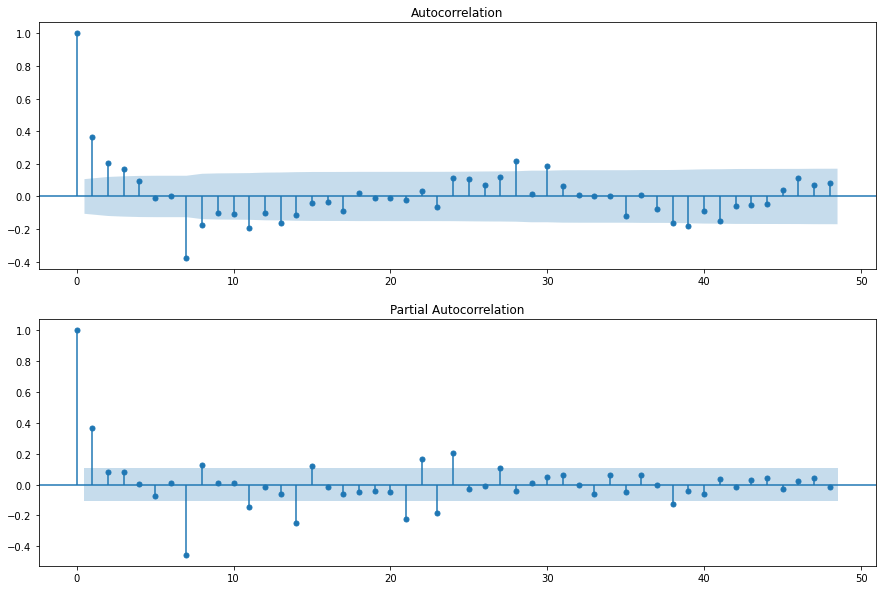

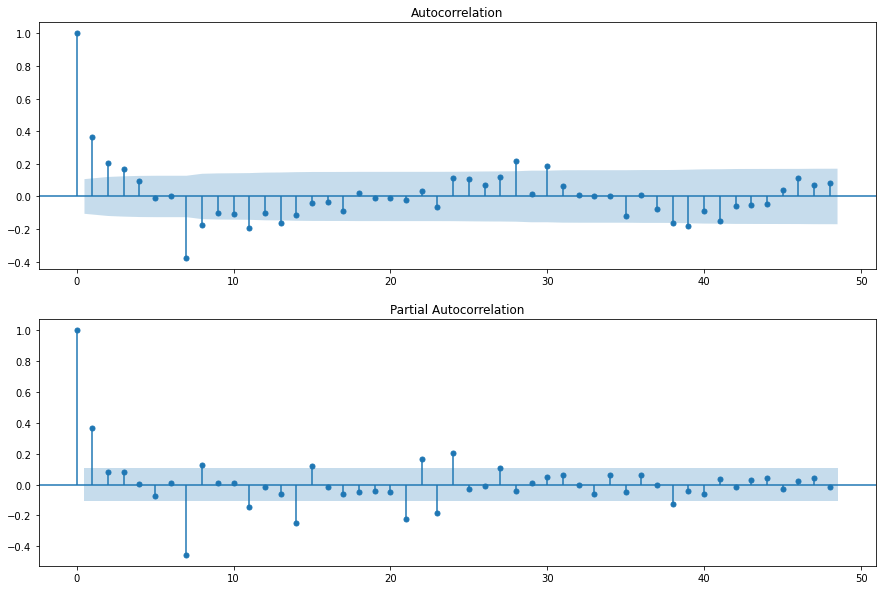

In [16]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [17]:
ps = 1
ds = range(0, 1)
qs = 2
Ps = 3
Ds = range(0, 2)
Qs = range(0, 1)

from itertools import product

parameters = product(ds, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

2

In [18]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.732841


In [22]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[0], param[0]), 
                                        seasonal_order=(param[0], param[0], param[0], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


  0%|          | 0/2 [00:00<?, ?it/s]/home/vlad/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/vlad/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/vlad/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/vlad/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

100%|██████████| 2/2 [00:00<00:00, 42.73it/s]

CPU times: user 52.3 ms, sys: 5 µs, total: 52.3 ms
Wall time: 52.7 ms


In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters          aic
0  (0, 0, 0)  5242.970473
1  (0, 1, 0)  5242.970473
